In [28]:
# === BIBLIOTECAS BÁSICAS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import re
import time
import warnings
import os
import gc
import pickle
warnings.filterwarnings('ignore')

# Para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configuración de gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# === INSTALACIÓN DE DEPENDENCIAS ===
print("=== INSTALACIÓN DE DEPENDENCIAS ===")
# Función para instalar paquetes si no están disponibles
def install_if_missing(package_name, import_name=None):
    if import_name is None:
        import_name = package_name

    try:
        __import__(import_name)
        print(f"✓ {package_name} ya está instalado")
    except ImportError:
        print(f"Instalando {package_name}...")
        import sys
        from subprocess import check_call
        check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"✓ {package_name} instalado correctamente")

# Instalación de paquetes necesarios
install_if_missing("tqdm")
install_if_missing("nltk")
install_if_missing("scikit-learn")
install_if_missing("xgboost")
install_if_missing("spacy")
install_if_missing("optuna")  # Para optimización de hiperparámetros
install_if_missing("imbalanced-learn")  # Para manejar el desbalance de clases
install_if_missing("wordcloud")  # Para visualización de palabras
install_if_missing("pysentimiento")  # Para análisis de sentimiento en español
install_if_missing("textblob")  # Alternativa para análisis de sentimiento

# Importar librerías
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                          roc_curve, auc, roc_auc_score, precision_recall_curve,
                          f1_score, precision_score, recall_score)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from wordcloud import WordCloud
from tqdm.notebook import tqdm

# Descarga de recursos necesarios para NLTK
print("\nDescargando recursos NLTK...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Cargar stopwords en español
from nltk.corpus import stopwords
spanish_stopwords = set(stopwords.words('spanish'))

# Cargar spaCy para español
try:
    import spacy
    try:
        nlp = spacy.load("es_core_news_sm")
        print("✓ Modelo spaCy español (small) cargado correctamente")
    except:
        print("Instalando modelo español para spaCy...")
        import sys
        from subprocess import check_call
        check_call([sys.executable, "-m", "spacy", "download", "es_core_news_sm"])
        nlp = spacy.load("es_core_news_sm")
        print("✓ Modelo spaCy español instalado y cargado")
except Exception as e:
    print(f"⚠️ Error al cargar spaCy: {e}")
    print("Usando un procesamiento de texto más básico")
    nlp = None

# Configurar análisis de sentimiento
try:
    import pysentimiento
    from pysentimiento.analyzer import SentimentAnalyzer
    sentiment_analyzer = SentimentAnalyzer(lang="es")
    print("✓ Analizador de sentimiento inicializado correctamente")
except Exception as e:
    sentiment_analyzer = None
    print(f"⚠️ Error al inicializar analizador de sentimiento: {e}")


=== INSTALACIÓN DE DEPENDENCIAS ===
✓ tqdm ya está instalado
✓ nltk ya está instalado
Instalando scikit-learn...
✓ scikit-learn instalado correctamente
✓ xgboost ya está instalado
✓ spacy ya está instalado
✓ optuna ya está instalado
Instalando imbalanced-learn...
✓ imbalanced-learn instalado correctamente
✓ wordcloud ya está instalado
✓ pysentimiento ya está instalado
✓ textblob ya está instalado

Descargando recursos NLTK...
✓ Modelo spaCy español (small) cargado correctamente
⚠️ Error al inicializar analizador de sentimiento: cannot import name 'SentimentAnalyzer' from 'pysentimiento.analyzer' (/usr/local/lib/python3.11/dist-packages/pysentimiento/analyzer.py)


In [92]:
# === CARGA Y PREPARACIÓN DE DATOS ===
print("\n=== CARGA DE DATOS ===")

def load_data(file_path):
    """Carga el dataset con manejo de errores y diagnóstico."""
    try:
        start_time = time.time()
        df = pd.read_csv(file_path)
        print(f"Dataset cargado con {df.shape[0]} registros y {df.shape[1]} columnas.")
        print(f"Tiempo de carga: {time.time() - start_time:.2f} segundos.")

        # Mostrar memoria utilizada
        mem_usage = df.memory_usage(deep=True).sum() / 1024**2
        print(f"Uso de memoria: {mem_usage:.2f} MB")

        # Verificar valores nulos
        null_counts = df.isnull().sum()
        null_percentages = (null_counts / len(df)) * 100
        null_info = pd.DataFrame({
            'Nulos': null_counts,
            'Porcentaje': null_percentages
        }).sort_values('Porcentaje', ascending=False)

        print("\nValores nulos por columna:")
        display(null_info[null_info['Nulos'] > 0])

        # Mostrar distribución de clases
        print("\nDistribución de clases:")
        if 'label' in df.columns:
            class_dist = df['label'].value_counts(normalize=True) * 100
            display(pd.DataFrame({
                'Conteos': df['label'].value_counts(),
                'Porcentaje': class_dist
            }))

        # Muestra de datos
        print("\nPrimeras filas del dataset:")
        display(df.head(3))

        return df

    except Exception as e:
        print(f"Error al cargar el dataset: {e}")
        print("Asegúrate de que el archivo esté en la ruta correcta.")
        return None

# Cargar el dataset
file_path = "fake_news_combined_clean.csv"
df = load_data(file_path)

if df is None:
    raise ValueError("No se pudo cargar el dataset. Verifica la ruta del archivo.")


=== CARGA DE DATOS ===
Dataset cargado con 4349 registros y 6 columnas.
Tiempo de carga: 0.24 segundos.
Uso de memoria: 11.53 MB

Valores nulos por columna:


,Nulos,Porcentaje
split,3092,71.096804
title,1500,34.490688
source,2,0.045988



Distribución de clases:


,Conteos,Porcentaje
label,,
Verdadera,2847,65.463325
Falsa,1502,34.536675



Primeras filas del dataset:


,label,content,title,source,split,dataset
0,Falsa,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",El Ruinaversal,train,posadas
1,Falsa,"La palabra ""haiga"", aceptada por la RAE La Rea...","La palabra ""haiga"", aceptada por la RAE",Hay noticia,train,posadas
2,Falsa,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,El Ruinaversal,train,posadas


In [93]:
df.head(-5)

,label,content,title,source,split,dataset
0,Falsa,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",El Ruinaversal,train,posadas
1,Falsa,"La palabra ""haiga"", aceptada por la RAE La Rea...","La palabra ""haiga"", aceptada por la RAE",Hay noticia,train,posadas
2,Falsa,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,El Ruinaversal,train,posadas
3,Verdadera,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,EL UNIVERSAL,train,posadas
4,Falsa,Alerta: pretenden aprobar libros escolares con...,pretenden aprobar libros escolares con conteni...,Lamula,train,posadas
...,...,...,...,...,...,...
4339,Verdadera,Source:SinEmbargoMX\n\n Prediction:True\n\n Co...,NaN,SinEmbargoMX,NaN,omdena
4340,Verdadera,Source:SinEmbargoMX\n\n Prediction:Fake\n\n Co...,NaN,SinEmbargoMX,NaN,omdena
4341,Verdadera,Source:El Mundo\n\n Prediction:True\n\n Conten...,Proponen que DUI tenga una vigencia de 15 años,El Mundo,NaN,omdena
4342,Verdadera,Source:proceso\n\n Prediction:True\n\n Content...,NaN,proceso,NaN,omdena


In [94]:
# === LIMPIEZA DE DATOS ===
print("\n=== LIMPIEZA DE DATOS ===")

def clean_dataset(df):
    """Realiza la limpieza inicial del dataset, modificando in-place 'content' y 'title'."""
    print(f"Dimensiones originales: {df.shape}")
    df = df.copy()

    # Helper para limpiar el contenido o título
    def clean_text(col, marker):
        s = col.astype(str)
        parts = s.str.split(fr'(?i){marker}:\s*', n=1, regex=True)
        extracted = parts.str[1].fillna(s)
        return (
            extracted
            .str.replace(r'http\S+|www\.\S+', '', regex=True)
            .str.replace(r'\n\s*\n+', '\n', regex=True)
            .str.replace(r'\s{2,}', ' ', regex=True)
            .str.strip()
        )

    # 1. Eliminar split
    if 'split' in df.columns:
        df.drop(columns=['split'], inplace=True)
        print("✓ Columna 'split' eliminada")

    # 2. Duplicados
    dup = df.duplicated().sum()
    if dup:
        print(f"Se encontraron {dup} duplicados → eliminando...")
        df.drop_duplicates(inplace=True)
    print(f"✓ Duplicados: {dup}")

    # 3. Nulos en title
    if 'title' in df.columns:
        n_null = df['title'].isnull().sum()
        if n_null:
            df['title'].fillna("No title", inplace=True)
            df['has_title'] = df['title'].ne("No title").astype(int)
            print(f"✓ {n_null} nulos en title → reemplazados y creada has_title")

    # 4. Nulos en content
    if 'content' in df.columns:
        n_null = df['content'].isnull().sum()
        if n_null:
            print(f"Advertencia: {n_null} registros sin content → eliminando...")
            df.dropna(subset=['content'], inplace=True)
        print(f"✓ Nulos en content: {n_null}")

    # 5. Nulos en source
    if 'source' in df.columns:
        n_null = df['source'].isnull().sum()
        if n_null:
            df['source'].fillna("No Source", inplace=True)
            df['has_source'] = df['source'].ne("No Source").astype(int)
            print(f"✓ {n_null} nulos en source → reemplazados y creada has_source")

    # 6. Limpieza in-place de 'content' y 'title'
    if 'content' in df.columns:
        df['content'] = clean_text(df['content'], marker='Content')
        print("✓ Columna 'content' limpiada (in-place)")

    if 'title' in df.columns:
        df['title'] = clean_text(df['title'], marker='Title')
        print("✓ Columna 'title' limpiada (in-place)")

    # 7. Estandarizar etiquetas
    if 'label' in df.columns:
        df['label'] = df['label'].apply(
            lambda x: "Falsa" if any(w in str(x).lower()
                                     for w in ['falsa','fake','false','bulo','rumor','mentira'])
                      else "Verdadera"
        )
        df['label_num'] = df['label'].map({"Falsa":0, "Verdadera":1})
        print("✓ Etiquetas estandarizadas (Falsa=0, Verdadera=1)")

    print(f"Dimensiones después de limpieza: {df.shape}")
    return df

# Limpiar dataset
df_clean = clean_dataset(df)


=== LIMPIEZA DE DATOS ===
Dimensiones originales: (4349, 6)
✓ Columna 'split' eliminada
Se encontraron 14 duplicados → eliminando...
✓ Duplicados: 14
✓ 1487 nulos en title → reemplazados y creada has_title
✓ Nulos en content: 0
✓ 2 nulos en source → reemplazados y creada has_source
✓ Columna 'content' limpiada (in-place)
✓ Columna 'title' limpiada (in-place)
✓ Etiquetas estandarizadas (Falsa=0, Verdadera=1)
Dimensiones después de limpieza: (4335, 8)


In [95]:
df_clean.head(-5)

,label,content,title,source,dataset,has_title,has_source,label_num
0,Falsa,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",El Ruinaversal,posadas,1,1,0
1,Falsa,"La palabra ""haiga"", aceptada por la RAE La Rea...","La palabra ""haiga"", aceptada por la RAE",Hay noticia,posadas,1,1,0
2,Falsa,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,El Ruinaversal,posadas,1,1,0
3,Verdadera,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,EL UNIVERSAL,posadas,1,1,1
4,Falsa,Alerta: pretenden aprobar libros escolares con...,pretenden aprobar libros escolares con conteni...,Lamula,posadas,1,1,0
...,...,...,...,...,...,...,...,...
4339,Verdadera,🔴 #EnVivo | #TercerInforme Andrés Manuel López...,No title,SinEmbargoMX,omdena,0,1,1
4340,Verdadera,Brigadas de vacunación contra COVID se reforza...,No title,SinEmbargoMX,omdena,0,1,1
4341,Verdadera,Los Duis actualmente tienen ocho años de vigen...,Proponen que DUI tenga una vigencia de 15 años,El Mundo,omdena,1,1,1
4342,Verdadera,Luego de que el presidente López Obrador cance...,No title,proceso,omdena,0,1,1


In [96]:
# === FUNCIONES DE PROCESAMIENTO DE TEXTO ===

def limpiar_texto(texto, stopwords=None):
    """Limpia el texto eliminando signos de puntuación, números y stopwords."""
    if pd.isna(texto) or texto is None:
        return ""

    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar URLs
    texto = re.sub(r'https?://\S+', '', texto)

    # Eliminar signos de puntuación y números
    texto = re.sub(r'[^\w\s]', ' ', texto)
    texto = re.sub(r'\d+', ' ', texto)

    # Tokenizar
    tokens = texto.split()

    # Eliminar stopwords si están disponibles
    if stopwords:
        tokens = [token for token in tokens if token not in stopwords]

    # Reconstruir texto
    return ' '.join(tokens)

# Antes de la función, inicializa globalmente tu analizador:
from pysentimiento import create_analyzer

try:
    sentiment_analyzer = create_analyzer(task="sentiment", lang="es")
    print("✓ PySentimiento listo")
except Exception as e:
    sentiment_analyzer = None
    print("⚠️ No fue posible inicializar PySentimiento:", e)

def analizar_sentimiento(texto):
    """Analiza el sentimiento de un texto en español usando PySentimiento (fallback: HuggingFace)."""
    # 1. Casos inválidos o demasiado cortos → respuesta neutral por defecto
    if pd.isna(texto) or not texto or len(texto.strip()) < 5:
        return {'sentiment': 'NEU', 'positive': 0.33, 'negative': 0.33, 'neutral': 0.34}

    # 2. Intentar con PySentimiento
    if sentiment_analyzer is not None:
        try:
            out = sentiment_analyzer.predict(texto)
            return {
                'sentiment': out.output,
                'positive': float(out.probas.get('POS', 0.0)),
                'negative': float(out.probas.get('NEG', 0.0)),
                'neutral' : float(out.probas.get('NEU', 0.0))
            }
        except Exception as e:
            print(f"Error en PySentimiento: {e}")

    # 3. Fallback: Transformers pipeline (si lo inicializaste)
    try:
        scores = sentiment_pipeline(texto)  # lista de dicts: [{'label':'NEG','score':...},...]
        # convertir a dict más cómodo
        probs = {d['label']: d['score'] for d in scores}
        # determinar etiqueta según mayor probabilidad
        best = max(probs, key=probs.get)
        return {
            'sentiment': best,
            'positive': probs.get('POS', 0.0),
            'negative': probs.get('NEG', 0.0),
            'neutral' : probs.get('NEU', 0.0)
        }
    except Exception:
        # 4. Si todo falla, neutral por defecto
        return {'sentiment': 'NEU', 'positive': 0.33, 'negative': 0.33, 'neutral': 0.34}


✓ PySentimiento listo



=== ANÁLISIS EXPLORATORIO DE DATOS ===
Limpiando textos para análisis...


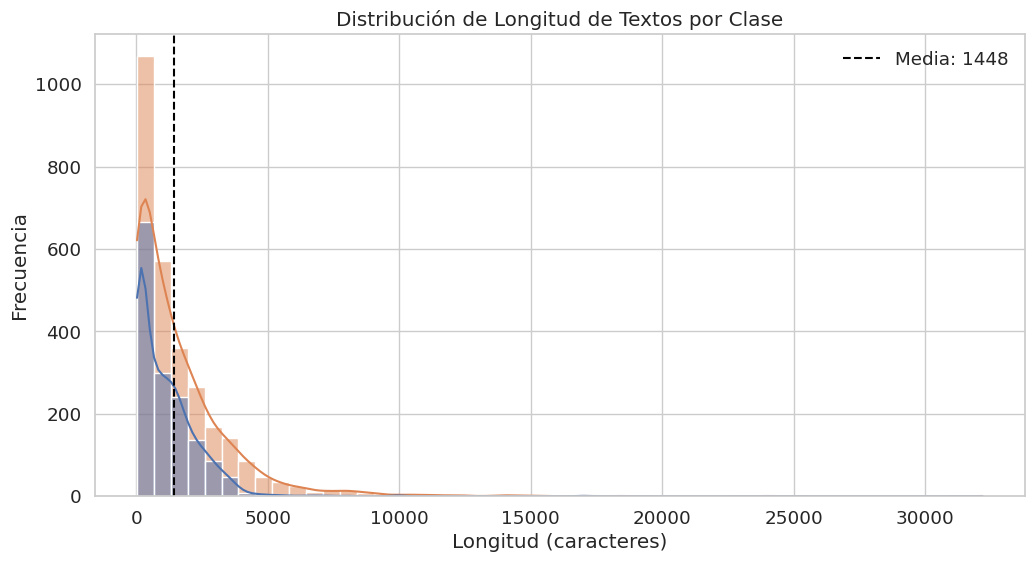

Estadísticas de longitud de texto por clase:


,mean,median,min,max,std
label,,,,,
Falsa,1118.835561,827.0,28,16940,1185.278428
Verdadera,1621.349419,1015.0,27,32178,2028.715931


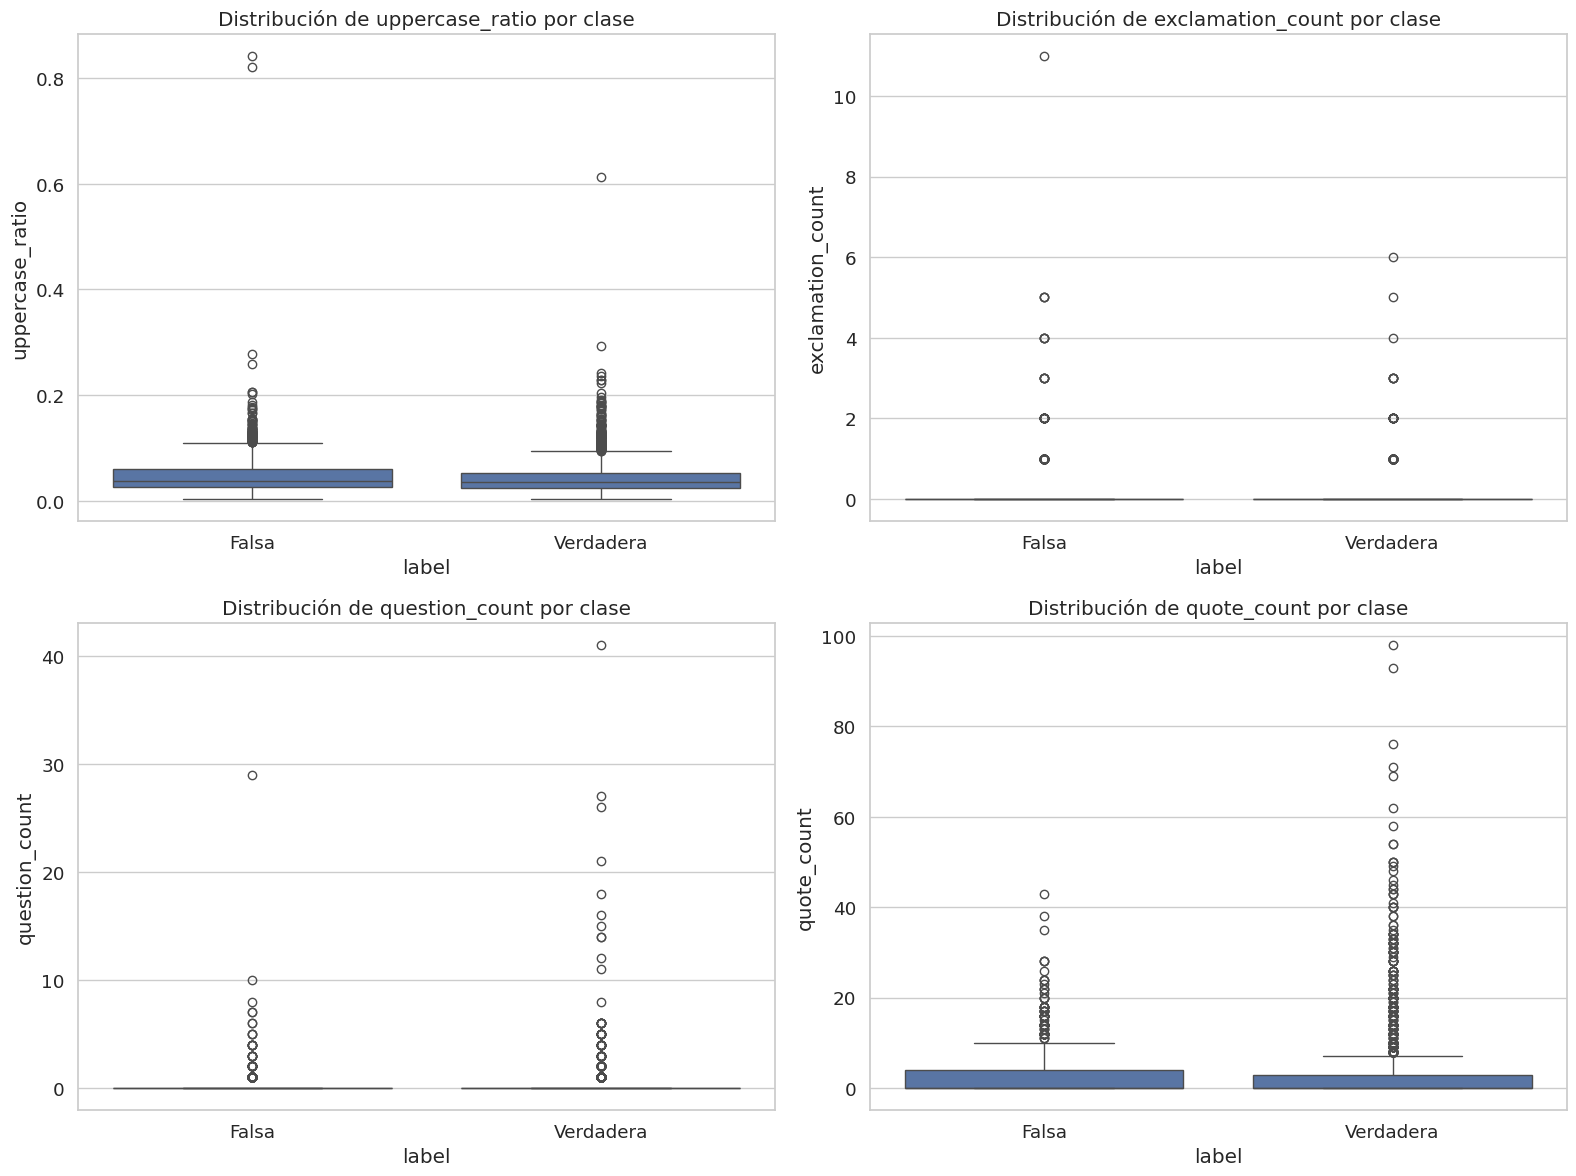

In [97]:
# === ANÁLISIS EXPLORATORIO DE DATOS ===
print("\n=== ANÁLISIS EXPLORATORIO DE DATOS ===")

# Limpiar textos para el análisis
print("Limpiando textos para análisis...")
df_clean['content_clean'] = df_clean['content'].apply(lambda x: limpiar_texto(x, spanish_stopwords))
df_clean['title_clean'] = df_clean['title'].apply(lambda x: limpiar_texto(x, spanish_stopwords))

# Analizar longitud de textos por clase
df_clean['text_length'] = df_clean['content'].apply(len)
df_clean['word_count'] = df_clean['content'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(data=df_clean, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribución de Longitud de Textos por Clase')
plt.xlabel('Longitud (caracteres)')
plt.ylabel('Frecuencia')
plt.axvline(df_clean['text_length'].mean(), color='black', linestyle='--', label=f'Media: {df_clean["text_length"].mean():.0f}')
plt.legend()
plt.show()

# Estadísticas de longitud por clase
print("Estadísticas de longitud de texto por clase:")
length_stats = df_clean.groupby('label')['text_length'].agg(['mean', 'median', 'min', 'max', 'std'])
display(length_stats)

# Características de formato
df_clean['uppercase_ratio'] = df_clean['content'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df_clean['exclamation_count'] = df_clean['content'].apply(lambda x: x.count('!'))
df_clean['question_count'] = df_clean['content'].apply(lambda x: x.count('?'))
df_clean['quote_count'] = df_clean['content'].apply(lambda x: x.count('"') + x.count("'"))

# Visualizar características por clase
features = ['uppercase_ratio', 'exclamation_count', 'question_count', 'quote_count']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='label', y=feature, data=df_clean, ax=axes[i])
    axes[i].set_title(f'Distribución de {feature} por clase')

plt.tight_layout()
plt.show()


=== ANÁLISIS DE SENTIMIENTO ===
Analizando sentimiento de 500 títulos...


  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

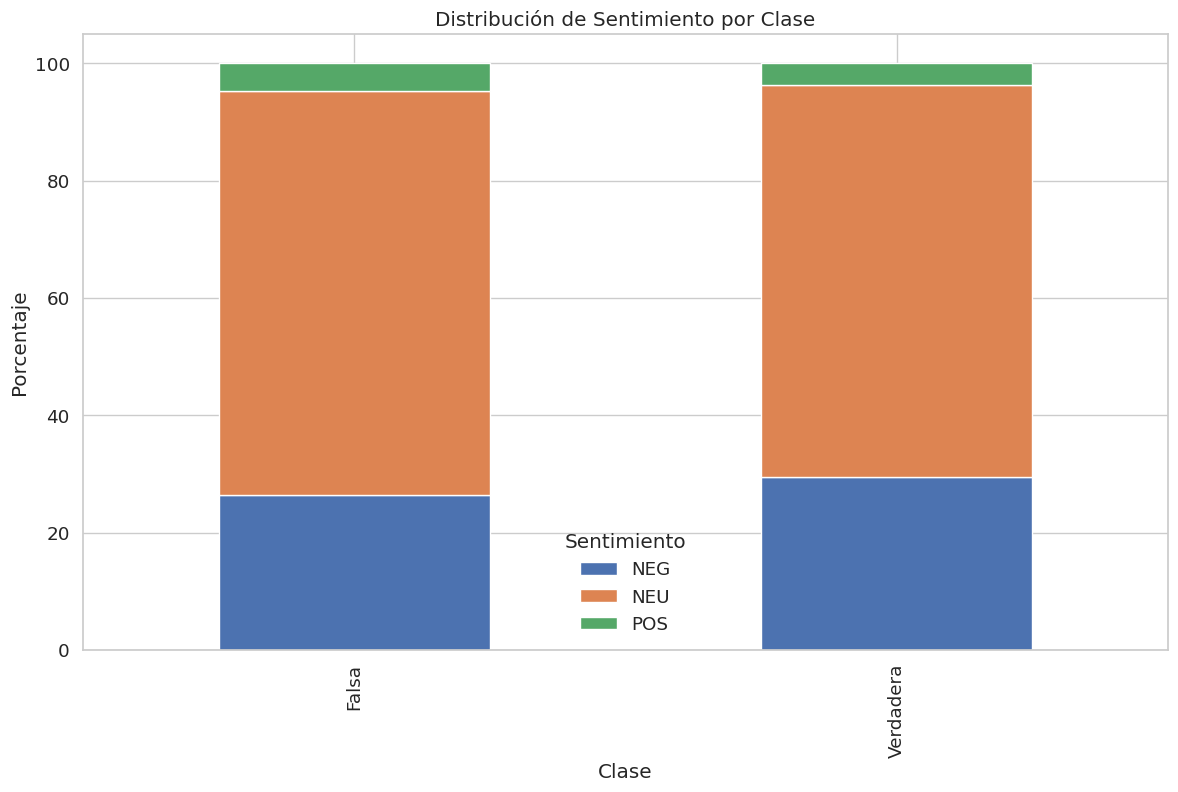

In [98]:
# === ANÁLISIS DE SENTIMIENTO ===
print("\n=== ANÁLISIS DE SENTIMIENTO ===")

# Analizar sentimiento de una muestra de títulos para no consumir demasiados recursos
sample_size = min(500, len(df_clean))
sample_indices = np.random.choice(df_clean.index, sample_size, replace=False)
df_sample = df_clean.loc[sample_indices]

print(f"Analizando sentimiento de {sample_size} títulos...")
title_sentiments = []
for title in tqdm(df_sample['title']):
    title_sentiments.append(analizar_sentimiento(title))

# Crear características de sentimiento
df_sample['title_sentiment'] = [s['sentiment'] for s in title_sentiments]
df_sample['title_positive'] = [s['positive'] for s in title_sentiments]
df_sample['title_negative'] = [s['negative'] for s in title_sentiments]

# Visualizar distribución de sentimiento por clase
sentiment_counts = pd.crosstab(df_sample['label'], df_sample['title_sentiment'])
sentiment_counts_pct = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sentiment_counts_pct.plot(kind='bar', stacked=True)
plt.title('Distribución de Sentimiento por Clase')
plt.xlabel('Clase')
plt.ylabel('Porcentaje')
plt.legend(title='Sentimiento')
plt.show()


=== EXTRACCIÓN DE CARACTERÍSTICAS AVANZADAS ===
Extrayendo características del texto...
Muestra aleatoria para análisis de sentimiento (1000 registros)...


Analizando sentimiento de títulos:   0%|          | 0/1000 [00:00<?, ?it/s]

Analizando sentimiento de contenido:   0%|          | 0/1000 [00:00<?, ?it/s]

Extracción completada: 36 características creadas

Primeras filas de características extraídas:


,text_length,title_length,word_count,title_word_count,sentence_count,uppercase_ratio,title_uppercase_ratio,exclamation_count,question_count,quote_count,...,title_sentiment,title_positive,title_negative,content_sentiment,content_positive,content_negative,title_sentiment_value,content_sentiment_value,sentiment_mismatch,emotional_words_ratio
0,2605,107,423,16,22,0.059885,0.822430,0,0,22,...,NEU,0.046874,0.14389,NEU,0.091346,0.139256,0,0,0,0.000000
1,1063,39,178,7,6,0.029163,0.102564,0,0,16,...,NEU,0.330000,0.33000,NEU,0.330000,0.330000,0,0,0,0.000000
2,2469,99,401,17,13,0.047388,0.838384,0,2,11,...,NEU,0.330000,0.33000,NEU,0.330000,0.330000,0,0,0,0.002392
3,1086,51,167,8,3,0.039595,0.098039,0,0,0,...,NEU,0.330000,0.33000,NEU,0.330000,0.330000,0,0,0,0.000000
4,5404,90,839,12,26,0.056440,0.000000,0,0,8,...,NEU,0.330000,0.33000,NEU,0.330000,0.330000,0,0,0,0.000000



Estadísticas básicas de las características:


,text_length,title_length,word_count,title_word_count,sentence_count,uppercase_ratio,title_uppercase_ratio,exclamation_count,question_count,quote_count,...,has_title,has_source,title_positive,title_negative,content_positive,content_negative,title_sentiment_value,content_sentiment_value,sentiment_mismatch,emotional_words_ratio
count,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,...,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000
mean,1447.932872,47.406920,236.730565,7.944637,9.958247,0.045658,0.099672,0.062053,0.245675,3.052364,...,0.656978,0.999539,0.285400,0.337656,0.284764,0.360249,-0.054210,-0.093426,0.098039,0.000833
std,1799.094073,33.140951,296.631633,5.225746,12.865742,0.035809,0.119941,0.387955,1.350397,6.831398,...,0.474774,0.021477,0.102090,0.115590,0.122306,0.157137,0.260568,0.351397,0.297402,0.004704
min,27.000000,8.000000,4.000000,1.000000,1.000000,0.004000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.003196,0.006048,0.002913,0.003416,-1.000000,-1.000000,0.000000,0.000000
25%,208.000000,8.000000,33.000000,2.000000,2.000000,0.025439,0.040000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.330000,0.330000,0.330000,0.330000,0.000000,0.000000,0.000000,0.000000
50%,952.000000,54.000000,157.000000,8.000000,6.000000,0.036697,0.085714,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.330000,0.330000,0.330000,0.330000,0.000000,0.000000,0.000000,0.000000
75%,2010.500000,72.000000,330.000000,12.000000,13.000000,0.055482,0.125000,0.000000,0.000000,4.000000,...,1.000000,1.000000,0.330000,0.330000,0.330000,0.330000,0.000000,0.000000,0.000000,0.000000
max,32178.000000,166.000000,5643.000000,28.000000,256.000000,0.842105,0.900000,11.000000,41.000000,98.000000,...,1.000000,1.000000,0.907804,0.972110,0.959387,0.977949,1.000000,1.000000,1.000000,0.100000



Características más correlacionadas con la etiqueta:
- title_uppercase_ratio: -0.1805
- sentence_count: 0.1345
- text_length: 0.1328
- word_count: 0.1277
- parenthesis_count: 0.1113
- url_count: nan
- repeated_words: 0.1359
- excl_quest_ratio: -0.0849
- symbol_ratio: -0.0705
- exclamation_count: -0.0640
- digit_ratio: 0.0595
- uppercase_ratio: -0.0553
- hashtag_count: -0.0538
- ellipsis_count: 0.0443
- content_negative: -0.0399


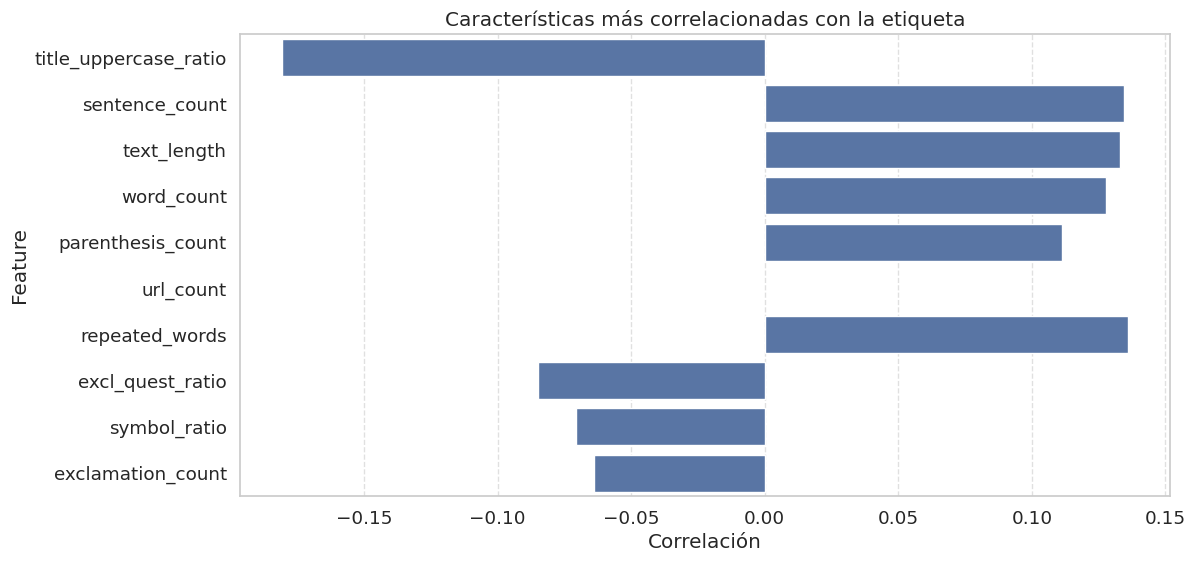

In [99]:
# === EXTRACCIÓN DE CARACTERÍSTICAS AVANZADAS ===
print("\n=== EXTRACCIÓN DE CARACTERÍSTICAS AVANZADAS ===")

def extract_text_features(df, content_col='content', title_col='title'):
    """Extrae características lingüísticas y de sentimiento avanzadas del texto."""
    print("Extrayendo características del texto...")

    # Crear un DataFrame para las nuevas características
    features_df = pd.DataFrame(index=df.index)

    # Características básicas de texto
    features_df['text_length'] = df[content_col].apply(len)
    features_df['title_length'] = df[title_col].apply(len)
    features_df['word_count'] = df[content_col].apply(lambda x: len(x.split()))
    features_df['title_word_count'] = df[title_col].apply(lambda x: len(x.split()))
    features_df['sentence_count'] = df[content_col].apply(lambda x: len(re.split(r'[.!?]+', x)))

    # Características de formato
    features_df['uppercase_ratio'] = df[content_col].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    features_df['title_uppercase_ratio'] = df[title_col].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    features_df['exclamation_count'] = df[content_col].apply(lambda x: x.count('!'))
    features_df['question_count'] = df[content_col].apply(lambda x: x.count('?'))
    features_df['quote_count'] = df[content_col].apply(lambda x: x.count('"') + x.count("'"))
    features_df['parenthesis_count'] = df[content_col].apply(lambda x: x.count('(') + x.count(')'))
    features_df['ellipsis_count'] = df[content_col].apply(lambda x: x.count('...'))

    # Características semánticas
    features_df['avg_word_length'] = df[content_col].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)
    features_df['avg_sentence_length'] = features_df.apply(lambda x: x['word_count'] / x['sentence_count'] if x['sentence_count'] > 0 else 0, axis=1)

    # Densidad de dígitos y símbolos especiales
    features_df['digit_ratio'] = df[content_col].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    features_df['symbol_ratio'] = df[content_col].apply(lambda x: sum(not c.isalnum() for c in x) / len(x) if len(x) > 0 else 0)

    # Presencia de URLs, hashtags y menciones
    features_df['url_count'] = df[content_col].apply(lambda x: len(re.findall(r'https?://\S+', x)))
    features_df['hashtag_count'] = df[content_col].apply(lambda x: len(re.findall(r'#\w+', x)))
    features_df['mention_count'] = df[content_col].apply(lambda x: len(re.findall(r'@\w+', x)))

    # Repetición de palabras (como indicador de énfasis)
    def count_repeated_words(text, min_length=4):
        words = re.findall(r'\b\w+\b', text.lower())
        words = [w for w in words if len(w) >= min_length]
        word_counts = {}
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1
        repeated_words = sum(1 for count in word_counts.values() if count > 1)
        return repeated_words

    features_df['repeated_words'] = df[content_col].apply(count_repeated_words)

    # Algunas características específicas que pueden ser indicativas de noticias falsas
    features_df['excl_quest_ratio'] = features_df.apply(
        lambda x: (x['exclamation_count'] + x['question_count']) / x['sentence_count'] if x['sentence_count'] > 0 else 0,
        axis=1
    )

    # Características de polaridad (palabras positivas/negativas en español mexicano)
    positive_words = {'bueno', 'excelente', 'increíble', 'maravilloso', 'feliz', 'alegre', 'positivo', 'éxito',
                     'victoria', 'beneficio', 'chido', 'padre', 'genial', 'chingón', 'maravilla'}

    negative_words = {'malo', 'terrible', 'horrible', 'triste', 'negativo', 'fracaso', 'derrota', 'perjuicio',
                     'desastre', 'crisis', 'gacho', 'culero', 'jodido', 'chafa'}

    def count_sentiment_words(text, word_set):
        text_lower = text.lower()
        count = sum(1 for word in word_set if f' {word} ' in f' {text_lower} ')
        return count

    features_df['positive_count'] = df[content_col].apply(lambda x: count_sentiment_words(x, positive_words))
    features_df['negative_count'] = df[content_col].apply(lambda x: count_sentiment_words(x, negative_words))
    features_df['sentiment_ratio'] = features_df.apply(
        lambda x: (x['positive_count'] - x['negative_count']) / (x['positive_count'] + x['negative_count'] + 1),
        axis=1
    )

    # Indicadores de presencia de título y fuente
    if 'has_title' in df.columns:
        features_df['has_title'] = df['has_title']

    if 'has_source' in df.columns:
        features_df['has_source'] = df['has_source']

    # Análisis de sentimiento (para una muestra)
    if len(df) > 1000:
        print("Muestra aleatoria para análisis de sentimiento (1000 registros)...")
        sample_indices = np.random.choice(df.index, min(1000, len(df)), replace=False)
        df_sentiment_sample = df.loc[sample_indices]
    else:
        df_sentiment_sample = df

    # Diccionarios para almacenar sentimientos
    title_sentiments = {}
    content_sentiments = {}

    # Analizar sentimiento de títulos
    for idx, title in tqdm(zip(df_sentiment_sample.index, df_sentiment_sample[title_col]),
                          desc="Analizando sentimiento de títulos", total=len(df_sentiment_sample)):
        title_sentiments[idx] = analizar_sentimiento(title)

    # Analizar sentimiento de contenido (muestrear primeras 200 palabras)
    for idx, content in tqdm(zip(df_sentiment_sample.index, df_sentiment_sample[content_col]),
                            desc="Analizando sentimiento de contenido", total=len(df_sentiment_sample)):
        # Analizar solo primeras 200 palabras para eficiencia
        content_sample = ' '.join(content.split()[:200])
        content_sentiments[idx] = analizar_sentimiento(content_sample)

    # Inicializar columnas de sentimiento con valores por defecto
    features_df['title_sentiment'] = 'NEU'
    features_df['title_positive'] = 0.33
    features_df['title_negative'] = 0.33
    features_df['content_sentiment'] = 'NEU'
    features_df['content_positive'] = 0.33
    features_df['content_negative'] = 0.33

    # Asignar valores de sentimiento para los índices analizados
    for idx in title_sentiments.keys():
        features_df.at[idx, 'title_sentiment'] = title_sentiments[idx]['sentiment']
        features_df.at[idx, 'title_positive'] = title_sentiments[idx]['positive']
        features_df.at[idx, 'title_negative'] = title_sentiments[idx]['negative']

    for idx in content_sentiments.keys():
        features_df.at[idx, 'content_sentiment'] = content_sentiments[idx]['sentiment']
        features_df.at[idx, 'content_positive'] = content_sentiments[idx]['positive']
        features_df.at[idx, 'content_negative'] = content_sentiments[idx]['negative']

    # Convertir sentimientos a valores numéricos
    sentiment_map = {'POS': 1, 'NEU': 0, 'NEG': -1, 'neutral': 0, 'positive': 1, 'negative': -1}
    features_df['title_sentiment_value'] = features_df['title_sentiment'].map(sentiment_map)
    features_df['content_sentiment_value'] = features_df['content_sentiment'].map(sentiment_map)

    # Diferencia de sentimiento entre título y contenido
    features_df['sentiment_mismatch'] = (features_df['title_sentiment_value'] != features_df['content_sentiment_value']).astype(int)

    # Proporciones de palabras con carga emocional
    total_words = features_df['word_count'] + features_df['title_word_count']
    features_df['emotional_words_ratio'] = (features_df['positive_count'] + features_df['negative_count']) / total_words.replace(0, 1)

    print(f"Extracción completada: {len(features_df.columns)} características creadas")
    return features_df

# Extraer características avanzadas
features_df = extract_text_features(df_clean)

# Mostrar las primeras filas y estadísticas básicas
print("\nPrimeras filas de características extraídas:")
display(features_df.head())

print("\nEstadísticas básicas de las características:")
display(features_df.describe())

# Correlación de características con la etiqueta
corr_with_label = []
for col in features_df.columns:
    if features_df[col].dtype in ['int64', 'float64']:
        corr = features_df[col].corr(df_clean['label_num'])
        corr_with_label.append((col, corr))

# Ordenar por valor absoluto de correlación
corr_with_label.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nCaracterísticas más correlacionadas con la etiqueta:")
for col, corr in corr_with_label[:15]:
    print(f"- {col}: {corr:.4f}")

# Visualizar top 10 correlaciones
corr_df = pd.DataFrame(corr_with_label[:10], columns=['Feature', 'Correlation'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Correlation', y='Feature', data=corr_df)
plt.title('Características más correlacionadas con la etiqueta')
plt.xlabel('Correlación')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [100]:
df_clean.tail()

,label,content,title,source,dataset,has_title,has_source,label_num,content_clean,title_clean,text_length,word_count,uppercase_ratio,exclamation_count,question_count,quote_count
4344,Verdadera,"Con tono grave, la dirigente regional ha lamen...",Ayuso niega la corrupción y reta a Casado a q...,El Periodico,omdena,1,1,1,tono grave dirigente regional lamentado choque...,ayuso niega corrupcio n reta casado demuestre ...,732,122,0.017760,0,0,5
4345,Verdadera,Tuvo que pasar una semana para que el gobierno...,No title,proceso,omdena,0,1,1,pasar semana gobierno andrés manuel lopezobrad...,title,207,37,0.024155,0,0,0
4346,Falsa,El ministro de Gobernación aseguró que los dip...,Durán: “cueste lo que cueste” se debe ampliar...,El Mundo,omdena,1,1,0,ministro gobernación aseguró diputados querían...,dura n cueste cueste debe ampliar voto exterior,1128,182,0.020390,0,0,0
4347,Verdadera,La Asamblea Legislativa aprobó con 79 votos un...,"Recomiendan subir el bono de policías, soldad...",El Mundo,omdena,1,1,1,asamblea legislativa aprobó votos decreto reco...,recomiendan subir bono polici as soldados cust...,1508,252,0.028515,0,0,0
4348,Falsa,El procurador dijo que la nueva ley debe garan...,Procurador deja a Asamblea decisión sobre pen...,El Mundo,omdena,1,1,0,procurador dijo nueva ley debe garantizar acce...,procurador deja asamblea decisio n penas cri m...,1334,226,0.026237,0,0,0


In [102]:
# === VECTORIZACIÓN DE TEXTO ===
print("\n=== VECTORIZACIÓN DE TEXTO ===")

def vectorize_text(df, content_col='content_clean', title_col='title_clean', max_features=5000):
   """Vectoriza el texto usando TF-IDF con configuración para español."""
   print(f"Vectorizando texto con TF-IDF (max_features={max_features})...")

   # Vectorizador para el contenido con configuración específica para español
   content_vectorizer = TfidfVectorizer(
       max_features=max_features,
       min_df=5,          # Ignorar términos que aparecen en menos de 5 documentos
       max_df=0.8,        # Ignorar términos que aparecen en más del 80% de los documentos
       sublinear_tf=True, # Aplicar escala sublineal a la frecuencia de términos
       use_idf=True,
       ngram_range=(1, 2), # Incluir unigramas y bigramas
       stop_words=list(spanish_stopwords),  # Usar stopwords en español
       strip_accents='unicode',  # Manejar acentos
       lowercase=True,    # Convertir a minúsculas
       analyzer='word',   # Analizar por palabras
       token_pattern=r'\b\w+\b'  # Patrón de token estándar para palabras
   )

   # Vectorizador para el título (menos características)
   title_vectorizer = TfidfVectorizer(
       max_features=max_features // 5,# Menos características para el título
       min_df=3,
       max_df=0.9,
       sublinear_tf=True,
       use_idf=True,
       ngram_range=(1, 2),
       stop_words=list(spanish_stopwords),
       strip_accents='unicode',
       lowercase=True
   )

   # Aplicar vectorización
   X_content = content_vectorizer.fit_transform(df[content_col])

   # Vectorizar títulos solo si no son todos "No title"
   if df[title_col].nunique() > 1:
       X_title = title_vectorizer.fit_transform(df[title_col])
       print(f"Contenido vectorizado: {X_content.shape[1]} características")
       print(f"Título vectorizado: {X_title.shape[1]} características")

       # Mostrar las principales características
       print("\nTop 15 términos más relevantes del contenido:")
       tfidf_sums = X_content.sum(axis=0).A1
       top_content_idx = np.argsort(tfidf_sums)[-15:]
       content_feature_names = content_vectorizer.get_feature_names_out()
       for idx in reversed(top_content_idx):
           print(f"- {content_feature_names[idx]}: {tfidf_sums[idx]:.4f}")

       print("\nTop 10 términos más relevantes del título:")
       tfidf_sums = X_title.sum(axis=0).A1
       top_title_idx = np.argsort(tfidf_sums)[-10:]
       title_feature_names = title_vectorizer.get_feature_names_out()
       for idx in reversed(top_title_idx):
           print(f"- {title_feature_names[idx]}: {tfidf_sums[idx]:.4f}")

       return content_vectorizer, title_vectorizer, X_content, X_title
   else:
       print(f"Contenido vectorizado: {X_content.shape[1]} características")
       print("Título no vectorizado (todos los valores son iguales)")

       # Mostrar las principales características
       print("\nTop 15 términos más relevantes del contenido:")
       tfidf_sums = X_content.sum(axis=0).A1
       top_content_idx = np.argsort(tfidf_sums)[-15:]
       content_feature_names = content_vectorizer.get_feature_names_out()
       for idx in reversed(top_content_idx):
           print(f"- {content_feature_names[idx]}: {tfidf_sums[idx]:.4f}")

       return content_vectorizer, None, X_content, None

# Vectorizar textos
content_vectorizer, title_vectorizer, X_content, X_title = vectorize_text(
    df_clean
)


=== VECTORIZACIÓN DE TEXTO ===
Vectorizando texto con TF-IDF (max_features=5000)...
Contenido vectorizado: 5000 características
Título vectorizado: 1000 características

Top 15 términos más relevantes del contenido:
- presidente: 91.0084
- prd: 89.9666
- amlo: 80.9336
- politica: 79.4208
- number: 76.7006
- pan: 73.6431
- mexico: 71.4122
- gobierno: 66.6332
- lopez: 64.9192
- dijo: 62.6557
- si: 61.2398
- obrador: 58.3266
- lopez obrador: 57.3774
- politico: 57.2918
- pais: 56.9269

Top 10 términos más relevantes del título:
- title: 1487.0000
- amlo: 49.4368
- number: 47.5342
- covid: 44.9718
- mexico: 36.8850
- gobierno: 34.8990
- pide: 30.3625
- ley: 29.4348
- bukele: 28.2770
- fmln: 27.6290


In [104]:
# === PREPARACIÓN DE DATOS PARA MODELADO ===
print("\n=== PREPARACIÓN DE DATOS PARA MODELADO ===")

def prepare_modeling_data(df, features_df, X_content, X_title=None, target_col='label_num'):
    """Prepara los datos para el modelado, combinando características."""
    # Convertir características a matriz - SOLO USAR COLUMNAS NUMÉRICAS
    features_numeric = features_df.select_dtypes(include=['int64', 'float64'])
    print(f"Solo usando {features_numeric.shape[1]} características numéricas de {features_df.shape[1]} totales")

    X_features = features_numeric.values

    # Normalizar características numéricas
    scaler = StandardScaler()
    X_features = scaler.fit_transform(X_features)

    print(f"Dimensiones de características numéricas: {X_features.shape}")
    print(f"Dimensiones de TF-IDF de contenido: {X_content.shape}")

    # Combinar todas las características
    if X_title is not None:
        print(f"Dimensiones de TF-IDF de título: {X_title.shape}")
        from scipy.sparse import hstack
        X_combined = hstack([X_content, X_title, X_features])
    else:
        from scipy.sparse import hstack
        X_combined = hstack([X_content, X_features])

    print(f"Dimensiones de características combinadas: {X_combined.shape}")

    # Preparar etiquetas
    y = df[target_col].values

    # Dividir en conjuntos de entrenamiento, validación y prueba
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_combined, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_SEED, stratify=y_train_val
    )

    print(f"\nConjunto de entrenamiento: {X_train.shape[0]} muestras")
    print(f"Conjunto de validación: {X_val.shape[0]} muestras")
    print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

    # Verificar distribución de clases
    train_class_dist = pd.Series(y_train).value_counts(normalize=True) * 100
    val_class_dist = pd.Series(y_val).value_counts(normalize=True) * 100
    test_class_dist = pd.Series(y_test).value_counts(normalize=True) * 100

    print("\nDistribución de clases:")
    print(f"Entrenamiento: Falsa={100-train_class_dist[1]:.1f}%, Verdadera={train_class_dist[1]:.1f}%")
    print(f"Validación: Falsa={100-val_class_dist[1]:.1f}%, Verdadera={val_class_dist[1]:.1f}%")
    print(f"Prueba: Falsa={100-test_class_dist[1]:.1f}%, Verdadera={test_class_dist[1]:.1f}%")

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

# Preparar datos para modelado
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_modeling_data(
   df_clean, features_df, X_content, X_title
)


=== PREPARACIÓN DE DATOS PARA MODELADO ===
Solo usando 34 características numéricas de 36 totales
Dimensiones de características numéricas: (4335, 34)
Dimensiones de TF-IDF de contenido: (4335, 5000)
Dimensiones de TF-IDF de título: (4335, 1000)
Dimensiones de características combinadas: (4335, 6034)

Conjunto de entrenamiento: 2601 muestras
Conjunto de validación: 867 muestras
Conjunto de prueba: 867 muestras

Distribución de clases:
Entrenamiento: Falsa=34.5%, Verdadera=65.5%
Validación: Falsa=34.5%, Verdadera=65.5%
Prueba: Falsa=34.5%, Verdadera=65.5%



=== EXPERIMENTACIÓN CON TÉCNICAS DE BALANCEO DE CLASES ===

1. Entrenando modelo sin balanceo...

2. Entrenando modelo con pesos de clase...

3. Entrenando modelo con SMOTE (sobremuestreo)...
Dimensiones después de SMOTE: (3406, 6034)

4. Entrenando modelo con submuestreo aleatorio...
Dimensiones después de submuestreo: (1796, 6034)

5. Entrenando modelo con combinación de técnicas (SMOTETomek)...
Dimensiones después de SMOTETomek: (3324, 6034)

Resultados de técnicas de balanceo (ordenados por F1-score):


,model_name,balance_method,accuracy,precision,recall,f1_score,auc
0,XGBoost,Sin balanceo,0.719723,0.729196,0.910211,0.809710,0.768283
4,XGBoost,SMOTETomek,0.728950,0.768116,0.839789,0.802355,0.774480
2,XGBoost,SMOTE,0.722030,0.770248,0.820423,0.794544,0.771674
1,XGBoost,Pesos de clase,0.709343,0.817269,0.716549,0.763602,0.787637
3,XGBoost,Submuestreo aleatorio,0.695502,0.829004,0.674296,0.743689,0.775425


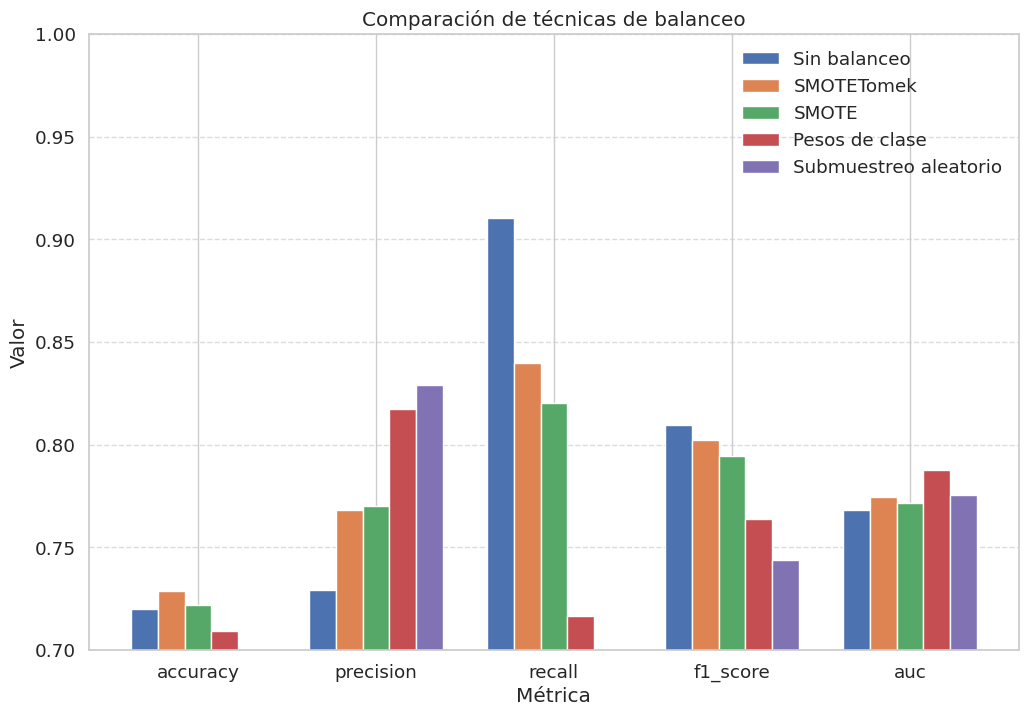


La mejor técnica de balanceo es: Sin balanceo


In [105]:
# === EXPERIMENTACIÓN CON TÉCNICAS DE BALANCEO DE CLASES ===
print("\n=== EXPERIMENTACIÓN CON TÉCNICAS DE BALANCEO DE CLASES ===")

def experiment_with_balancing(X_train, y_train, X_val, y_val):
   """Experimenta con diferentes técnicas de balanceo de clases."""
   results = []

   # Definir evaluador de rendimiento
   def evaluate_model(model, X, y, model_name, balance_method):
       y_pred = model.predict(X)

       acc = accuracy_score(y, y_pred)
       prec = precision_score(y, y_pred)
       rec = recall_score(y, y_pred)
       f1 = f1_score(y, y_pred)

       # Calcular AUC si el modelo tiene predict_proba
       if hasattr(model, 'predict_proba'):
           y_prob = model.predict_proba(X)[:, 1]
           auc_score = roc_auc_score(y, y_prob)
       else:
           auc_score = np.nan

       return {
           'model_name': model_name,
           'balance_method': balance_method,
           'accuracy': acc,
           'precision': prec,
           'recall': rec,
           'f1_score': f1,
           'auc': auc_score
       }

   # 1. Sin balanceo (línea base)
   print("\n1. Entrenando modelo sin balanceo...")
   model_base = xgb.XGBClassifier(
       n_estimators=100,
       learning_rate=0.1,
       max_depth=5,
       random_state=RANDOM_SEED,
       use_label_encoder=False,
       eval_metric='logloss'
   )

   model_base.fit(X_train, y_train)

   base_results = evaluate_model(model_base, X_val, y_val, "XGBoost", "Sin balanceo")
   results.append(base_results)

   # 2. Usar pesos de clase
   print("\n2. Entrenando modelo con pesos de clase...")
   # Calcular pesos de clase
   class_weights = len(y_train) / (2 * np.bincount(y_train))
   sample_weights = np.ones(len(y_train))
   for i in range(len(y_train)):
       sample_weights[i] = class_weights[y_train[i]]

   model_weights = xgb.XGBClassifier(
       n_estimators=100,
       learning_rate=0.1,
       max_depth=5,
       random_state=RANDOM_SEED,
       use_label_encoder=False,
       eval_metric='logloss'
   )

   model_weights.fit(X_train, y_train, sample_weight=sample_weights)

   weights_results = evaluate_model(model_weights, X_val, y_val, "XGBoost", "Pesos de clase")
   results.append(weights_results)

   # 3. Sobremuestreo (SMOTE)
   print("\n3. Entrenando modelo con SMOTE (sobremuestreo)...")
   try:
       from imblearn.over_sampling import SMOTE

       smote = SMOTE(random_state=RANDOM_SEED)
       X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

       model_smote = xgb.XGBClassifier(
           n_estimators=100,
           learning_rate=0.1,
           max_depth=5,
           random_state=RANDOM_SEED,
           use_label_encoder=False,
           eval_metric='logloss'
       )

       model_smote.fit(X_train_smote, y_train_smote)

       smote_results = evaluate_model(model_smote, X_val, y_val, "XGBoost", "SMOTE")
       results.append(smote_results)

       print(f"Dimensiones después de SMOTE: {X_train_smote.shape}")
   except Exception as e:
       print(f"Error al aplicar SMOTE: {e}")

   # 4. Submuestreo aleatorio
   print("\n4. Entrenando modelo con submuestreo aleatorio...")
   try:
       from imblearn.under_sampling import RandomUnderSampler

       rus = RandomUnderSampler(random_state=RANDOM_SEED)
       X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

       model_rus = xgb.XGBClassifier(
           n_estimators=100,
           learning_rate=0.1,
           max_depth=5,
           random_state=RANDOM_SEED,
           use_label_encoder=False,
           eval_metric='logloss'
       )

       model_rus.fit(X_train_rus, y_train_rus)

       rus_results = evaluate_model(model_rus, X_val, y_val, "XGBoost", "Submuestreo aleatorio")
       results.append(rus_results)

       print(f"Dimensiones después de submuestreo: {X_train_rus.shape}")
   except Exception as e:
       print(f"Error al aplicar submuestreo: {e}")

   # 5. Combinación de sobremuestreo y submuestreo (SMOTETomek)
   print("\n5. Entrenando modelo con combinación de técnicas (SMOTETomek)...")
   try:
       from imblearn.combine import SMOTETomek

       smote_tomek = SMOTETomek(random_state=RANDOM_SEED)
       X_train_combo, y_train_combo = smote_tomek.fit_resample(X_train, y_train)

       model_combo = xgb.XGBClassifier(
           n_estimators=100,
           learning_rate=0.1,
           max_depth=5,
           random_state=RANDOM_SEED,
           use_label_encoder=False,
           eval_metric='logloss'
       )

       model_combo.fit(X_train_combo, y_train_combo)

       combo_results = evaluate_model(model_combo, X_val, y_val, "XGBoost", "SMOTETomek")
       results.append(combo_results)

       print(f"Dimensiones después de SMOTETomek: {X_train_combo.shape}")
   except Exception as e:
       print(f"Error al aplicar SMOTETomek: {e}")

   # Comparar resultados
   results_df = pd.DataFrame(results)

   # Ordenar por F1-score (podemos cambiar a otra métrica si queremos)
   results_df = results_df.sort_values('f1_score', ascending=False)

   print("\nResultados de técnicas de balanceo (ordenados por F1-score):")
   display(results_df)

   # Visualizar resultados
   plt.figure(figsize=(12, 8))

   metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
   bar_width = 0.15
   r = np.arange(len(metrics))

   for i, method in enumerate(results_df['balance_method']):
       values = [results_df[results_df['balance_method'] == method][metric].values[0] for metric in metrics]
       plt.bar(r + i * bar_width, values, width=bar_width, label=method)

   plt.xlabel('Métrica')
   plt.ylabel('Valor')
   plt.title('Comparación de técnicas de balanceo')
   plt.xticks(r + bar_width * 2, metrics)
   plt.legend()
   plt.ylim(0.7, 1.0)  # Ajustar según tus resultados
   plt.grid(axis='y', linestyle='--', alpha=0.7)
   plt.show()

   # Devolver la mejor técnica y su modelo
   best_method = results_df.iloc[0]['balance_method']
   print(f"\nLa mejor técnica de balanceo es: {best_method}")

   if best_method == "Sin balanceo":
       return model_base, best_method
   elif best_method == "Pesos de clase":
       return model_weights, best_method
   elif best_method == "SMOTE":
       return model_smote, best_method
   elif best_method == "Submuestreo aleatorio":
       return model_rus, best_method
   elif best_method == "SMOTETomek":
       return model_combo, best_method
   else:
       return model_base, "Sin balanceo"  # Por defecto

# Experimentar con técnicas de balanceo
best_model, best_balance_method = experiment_with_balancing(X_train, y_train, X_val, y_val)


In [111]:
# === OPTIMIZACIÓN DE HIPERPARÁMETROS ===
print("\n=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===")

def optimize_hyperparameters(X_train, y_train, X_val, y_val, balance_method):
   """Optimiza hiperparámetros con Optuna."""
   print(f"Optimizando hiperparámetros para XGBoost con balanceo: {balance_method}")

   # Preparar datos según el método de balanceo
   if balance_method == "SMOTE":
       smote = SMOTE(random_state=RANDOM_SEED)
       X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
   elif balance_method == "Submuestreo aleatorio":
       rus = RandomUnderSampler(random_state=RANDOM_SEED)
       X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
   elif balance_method == "SMOTETomek":
       from imblearn.combine import SMOTETomek
       smote_tomek = SMOTETomek(random_state=RANDOM_SEED)
       X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
   elif balance_method == "Pesos de clase":
       # Usar pesos en vez de remuestreo
       X_resampled, y_resampled = X_train, y_train
       class_weights = len(y_train) / (2 * np.bincount(y_train))
       sample_weights = np.ones(len(y_train))
       for i in range(len(y_train)):
           sample_weights[i] = class_weights[y_train[i]]
   else:  # "Sin balanceo"
       X_resampled, y_resampled = X_train, y_train
       sample_weights = None

   # Función objetivo para Optuna
   def objective(trial):
       # Definir espacio de hiperparámetros
       params = {
           'n_estimators': trial.suggest_int('n_estimators', 100, 500),
           'max_depth': trial.suggest_int('max_depth', 3, 8),
           'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
           'subsample': trial.suggest_float('subsample', 0.6, 1.0),
           'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
           'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
           'gamma': trial.suggest_float('gamma', 0, 0.5),
           'alpha': trial.suggest_float('alpha', 0, 1.0),
           'lambda': trial.suggest_float('lambda', 0.5, 2.0),
           'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0) if balance_method == "Sin balanceo" else 1.0,
       }

       # Crear y entrenar modelo
       model = xgb.XGBClassifier(
           **params,
           random_state=RANDOM_SEED,
           use_label_encoder=False,
           eval_metric='logloss'
       )

       # Entrenar con o sin pesos según el método
       if balance_method == "Pesos de clase":
           model.fit(X_resampled, y_resampled, sample_weight=sample_weights)
       else:
           model.fit(X_resampled, y_resampled)

       # Evaluar en conjunto de validación
       y_pred = model.predict(X_val)
       f1 = f1_score(y_val, y_pred)

       return f1

   # Crear estudio de optimización
   import optuna
   optuna.logging.set_verbosity(optuna.logging.WARNING)

   print("Ejecutando optimización (esto puede tomar varios minutos)...")
   study = optuna.create_study(direction='maximize')
   study.optimize(objective, n_trials=20, show_progress_bar=True)

   # Mostrar mejores hiperparámetros y resultados
   print("\nMejores hiperparámetros encontrados:")
   for key, value in study.best_params.items():
       print(f"- {key}: {value}")

   print(f"\nMejor F1-score: {study.best_value:.4f}")

   # Entrenar modelo final con mejores hiperparámetros
   final_model = xgb.XGBClassifier(
       **study.best_params,
       random_state=RANDOM_SEED,
       use_label_encoder=False,
       eval_metric='logloss'
   )

   # Entrenar con el mejor método de balanceo
   if balance_method == "Pesos de clase":
       final_model.fit(X_resampled, y_resampled, sample_weight=sample_weights)
   else:
       final_model.fit(X_resampled, y_resampled)

   return final_model, study.best_params

# Optimizar hiperparámetros - comentar si toma demasiado tiempo
optimized_model, best_params = optimize_hyperparameters(X_train, y_train, X_val, y_val, best_balance_method)



=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===
Optimizando hiperparámetros para XGBoost con balanceo: Sin balanceo
Ejecutando optimización (esto puede tomar varios minutos)...


  0%|          | 0/20 [00:00<?, ?it/s]


Mejores hiperparámetros encontrados:
- n_estimators: 318
- max_depth: 4
- learning_rate: 0.07527410320959399
- subsample: 0.6791748227498481
- colsample_bytree: 0.7483826594472829
- min_child_weight: 2
- gamma: 0.22597866871491118
- alpha: 0.7123473267847061
- lambda: 1.2867912035994296
- scale_pos_weight: 1.714909547599437

Mejor F1-score: 0.8285



=== EVALUACIÓN FINAL DEL MODELO ===
Métricas en conjunto de prueba:
Accuracy: 0.7393
Precision: 0.7311
Recall: 0.9525
F1-score: 0.8272
AUC: 0.7778

Reporte de clasificación detallado:
              precision    recall  f1-score   support

       Falsa       0.79      0.33      0.47       299
   Verdadera       0.73      0.95      0.83       568

    accuracy                           0.74       867
   macro avg       0.76      0.64      0.65       867
weighted avg       0.75      0.74      0.70       867



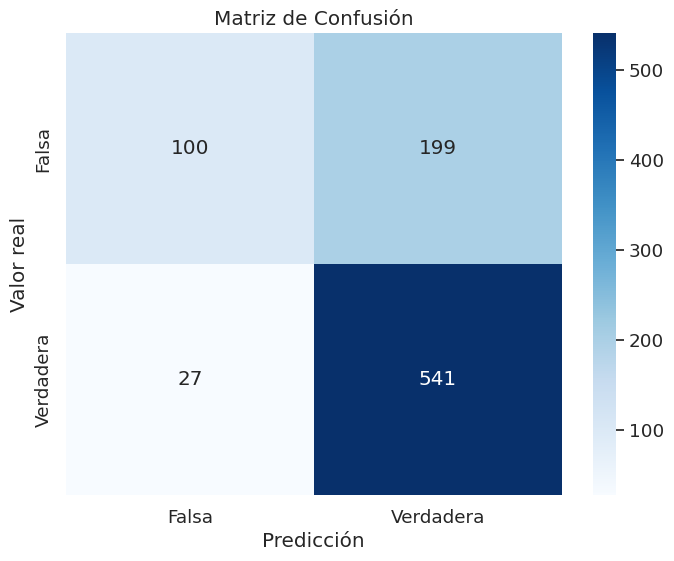

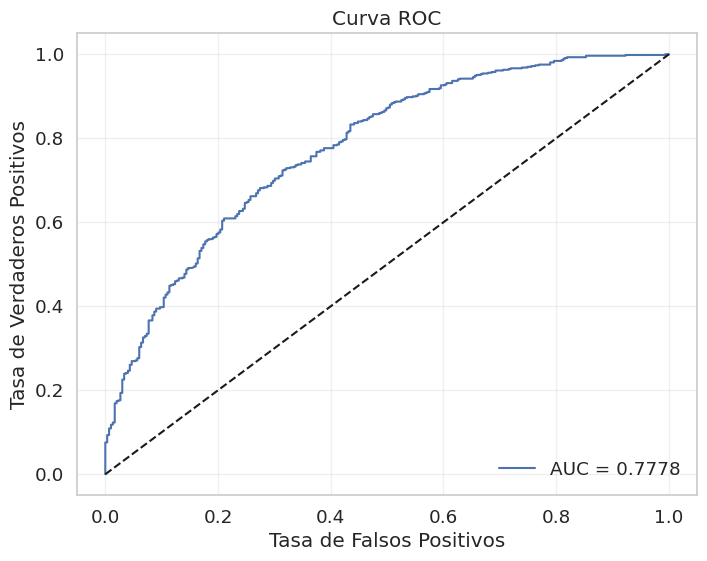

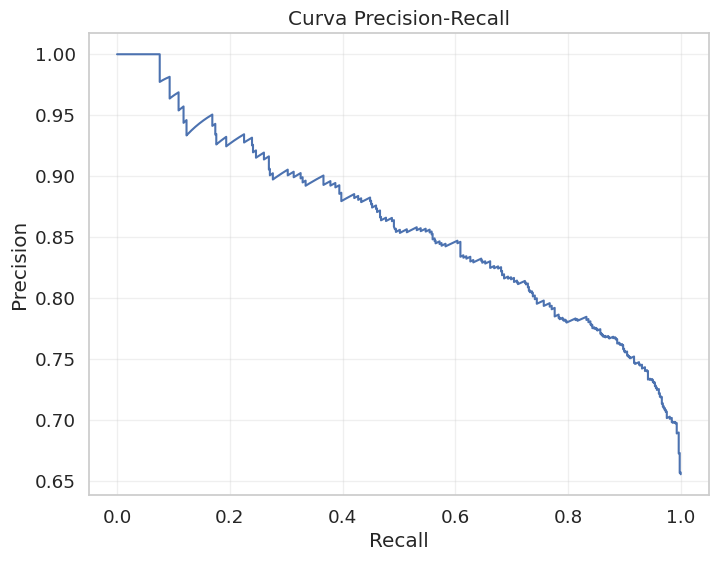

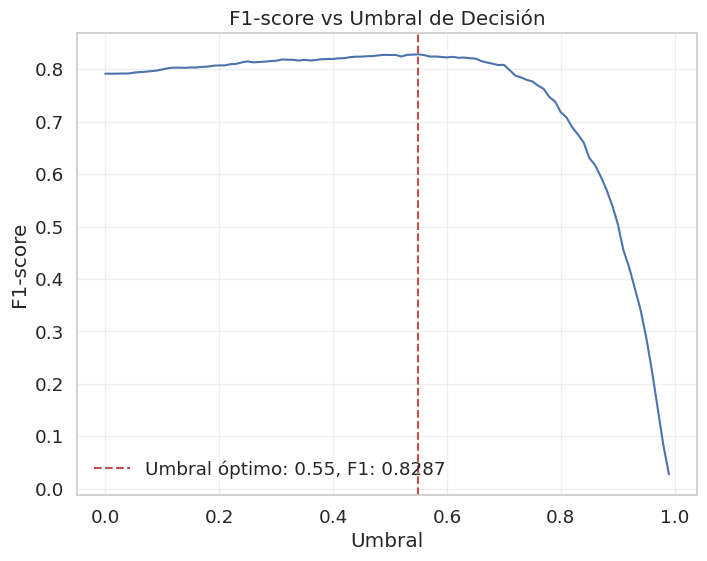


Métricas con umbral óptimo (0.55):
              precision    recall  f1-score   support

       Falsa       0.76      0.38      0.51       299
   Verdadera       0.74      0.94      0.83       568

    accuracy                           0.75       867
   macro avg       0.75      0.66      0.67       867
weighted avg       0.75      0.75      0.72       867


Comparación de rendimiento entre conjuntos:
Entrenamiento - Accuracy: 0.8727, F1: 0.9110
Validación - Accuracy: 0.7393, F1: 0.8285
Prueba - Accuracy: 0.7393, F1: 0.8272

⚠️ Posible overfitting detectado (diferencia significativa entre entrenamiento y prueba)


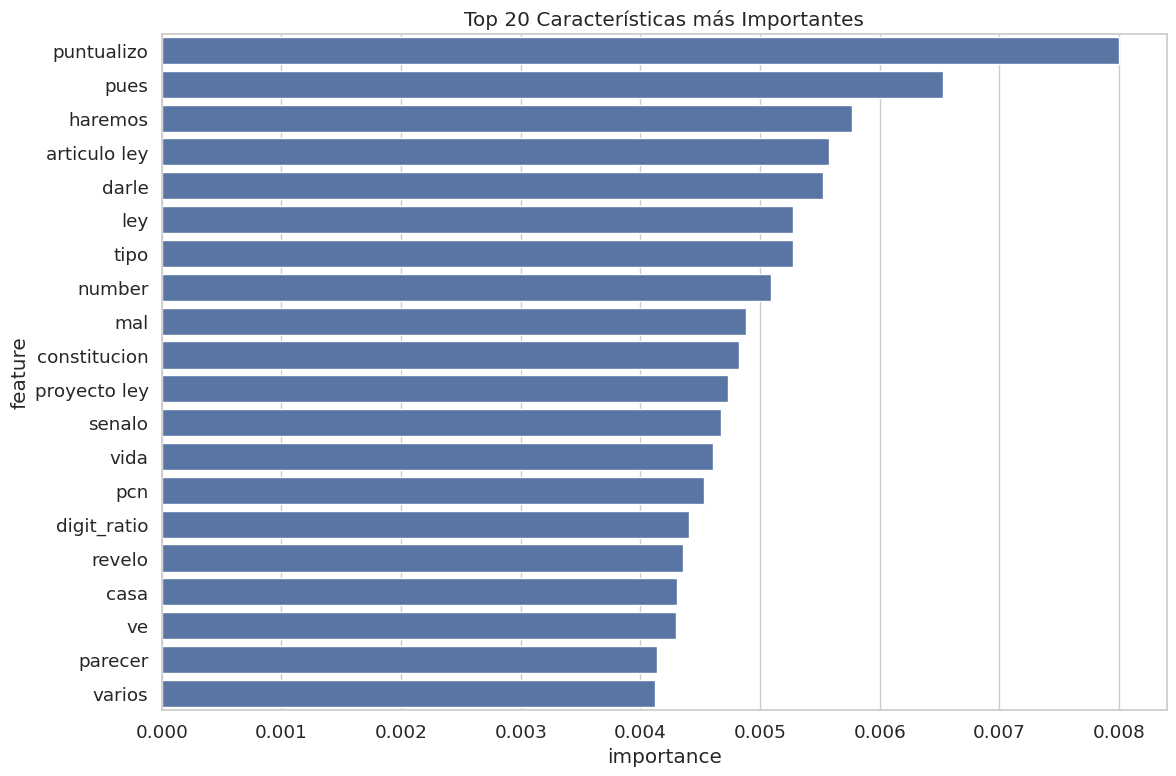


Top 10 características más importantes:
- puntualizo: 0.0080
- pues: 0.0065
- haremos: 0.0058
- articulo ley: 0.0056
- darle: 0.0055
- ley: 0.0053
- tipo: 0.0053
- number: 0.0051
- mal: 0.0049
- constitucion: 0.0048


In [112]:
# === EVALUACIÓN FINAL DEL MODELO ===
print("\n=== EVALUACIÓN FINAL DEL MODELO ===")

def evaluate_final_model(model, X_test, y_test, X_train=None, y_train=None, X_val=None, y_val=None):
   """Realiza una evaluación completa del modelo final."""
   # Evaluación en conjunto de prueba
   y_pred = model.predict(X_test)
   y_prob = model.predict_proba(X_test)[:, 1]

   # Calcular métricas principales
   accuracy = accuracy_score(y_test, y_pred)
   precision = precision_score(y_test, y_pred)
   recall = recall_score(y_test, y_pred)
   f1 = f1_score(y_test, y_pred)
   auc_value = roc_auc_score(y_test, y_prob)

   print("Métricas en conjunto de prueba:")
   print(f"Accuracy: {accuracy:.4f}")
   print(f"Precision: {precision:.4f}")
   print(f"Recall: {recall:.4f}")
   print(f"F1-score: {f1:.4f}")
   print(f"AUC: {auc_value:.4f}")

   # Reporte de clasificación detallado
   print("\nReporte de clasificación detallado:")
   print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))

   # Matriz de confusión
   conf_matrix = confusion_matrix(y_test, y_pred)
   plt.figure(figsize=(8, 6))
   sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Falsa', 'Verdadera'],
               yticklabels=['Falsa', 'Verdadera'])
   plt.xlabel('Predicción')
   plt.ylabel('Valor real')
   plt.title('Matriz de Confusión')
   plt.show()

   # Curva ROC
   fpr, tpr, _ = roc_curve(y_test, y_prob)
   plt.figure(figsize=(8, 6))
   plt.plot(fpr, tpr, label=f'AUC = {auc_value:.4f}')
   plt.plot([0, 1], [0, 1], 'k--')
   plt.xlabel('Tasa de Falsos Positivos')
   plt.ylabel('Tasa de Verdaderos Positivos')
   plt.title('Curva ROC')
   plt.legend(loc='lower right')
   plt.grid(alpha=0.3)
   plt.show()

   # Curva de precisión-recall
   precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
   plt.figure(figsize=(8, 6))
   plt.plot(recall_curve, precision_curve)
   plt.xlabel('Recall')
   plt.ylabel('Precision')
   plt.title('Curva Precision-Recall')
   plt.grid(alpha=0.3)
   plt.show()

   # Umbral óptimo
   thresholds = np.arange(0, 1, 0.01)
   f1_scores = []

   for threshold in thresholds:
       y_pred_t = (y_prob >= threshold).astype(int)
       f1_t = f1_score(y_test, y_pred_t)
       f1_scores.append(f1_t)

   best_threshold = thresholds[np.argmax(f1_scores)]
   best_f1 = max(f1_scores)

   plt.figure(figsize=(8, 6))
   plt.plot(thresholds, f1_scores)
   plt.axvline(x=best_threshold, color='r', linestyle='--',
               label=f'Umbral óptimo: {best_threshold:.2f}, F1: {best_f1:.4f}')
   plt.xlabel('Umbral')
   plt.ylabel('F1-score')
   plt.title('F1-score vs Umbral de Decisión')
   plt.legend()
   plt.grid(alpha=0.3)
   plt.show()

   # Predicciones con umbral óptimo
   y_pred_opt = (y_prob >= best_threshold).astype(int)
   print(f"\nMétricas con umbral óptimo ({best_threshold:.2f}):")
   print(classification_report(y_test, y_pred_opt, target_names=['Falsa', 'Verdadera']))

   # Evaluar rendimiento en conjuntos de entrenamiento y validación (para detectar overfitting)
   if X_train is not None and y_train is not None:
       train_pred = model.predict(X_train)
       train_acc = accuracy_score(y_train, train_pred)
       train_f1 = f1_score(y_train, train_pred)

       print("\nComparación de rendimiento entre conjuntos:")
       print(f"Entrenamiento - Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")

       if X_val is not None and y_val is not None:
           val_pred = model.predict(X_val)
           val_acc = accuracy_score(y_val, val_pred)
           val_f1 = f1_score(y_val, val_pred)
           print(f"Validación - Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")

       print(f"Prueba - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

       # Verificar posible overfitting
       if train_f1 - f1 > 0.05:
           print("\n⚠️ Posible overfitting detectado (diferencia significativa entre entrenamiento y prueba)")

   # Análisis de características importantes
   if hasattr(model, 'feature_importances_'):
       n_features = 20  # Mostrar top 20 características
       importances = model.feature_importances_

       # Conseguir nombres de características (combinando vectorizador TF-IDF y características numéricas)
       feature_names = []
       if hasattr(content_vectorizer, 'get_feature_names_out'):
           feature_names.extend(content_vectorizer.get_feature_names_out())

       if title_vectorizer is not None and hasattr(title_vectorizer, 'get_feature_names_out'):
           title_features = [f"title_{f}" for f in title_vectorizer.get_feature_names_out()]
           feature_names.extend(title_features)

       # Añadir nombres de características numéricas
       feature_names.extend(features_df.columns)

       # Limitar al número real de características en el modelo
       max_idx = min(len(feature_names), len(importances))
       feature_names = feature_names[:max_idx]
       importances = importances[:max_idx]

       # Crear DataFrame con importancias
       feature_importance = pd.DataFrame({
           'feature': feature_names[:len(importances)],
           'importance': importances
       })

       # Ordenar por importancia
       feature_importance = feature_importance.sort_values('importance', ascending=False)

       # Mostrar top N características
       top_features = feature_importance.head(n_features)

       plt.figure(figsize=(12, 8))
       sns.barplot(x='importance', y='feature', data=top_features)
       plt.title(f'Top {n_features} Características más Importantes')
       plt.tight_layout()
       plt.show()

       print("\nTop 10 características más importantes:")
       for i, row in top_features.head(10).iterrows():
           print(f"- {row['feature']}: {row['importance']:.4f}")

   return {
       'accuracy': accuracy,
       'precision': precision,
       'recall': recall,
       'f1_score': f1,
       'auc': auc_value,
       'best_threshold': best_threshold,
       'best_f1': best_f1
   }

# Evaluar modelo final
final_metrics = evaluate_final_model(
   optimized_model, X_test, y_test, X_train, y_train, X_val, y_val
)

In [113]:
# === ANÁLISIS DE ERRORES ===
print("\n=== ANÁLISIS DE ERRORES ===")

def analyze_errors(model, X_test, y_test, df_test):
   """Analiza los errores de predicción para entender mejor el comportamiento del modelo."""
   # Hacer predicciones
   y_pred = model.predict(X_test)
   y_prob = model.predict_proba(X_test)[:, 1]

   # Crear DataFrame con predicciones
   df_results = pd.DataFrame({
       'real': y_test,
       'prediccion': y_pred,
       'probabilidad': y_prob
   })

   df_results['correcto'] = df_results['real'] == df_results['prediccion']

   # Identificar falsos positivos y falsos negativos
   df_results['tipo_error'] = 'Correcto'
   df_results.loc[(df_results['real'] == 0) & (df_results['prediccion'] == 1), 'tipo_error'] = 'Falso Positivo'
   df_results.loc[(df_results['real'] == 1) & (df_results['prediccion'] == 0), 'tipo_error'] = 'Falso Negativo'

   # Estadísticas de errores
   error_counts = df_results['tipo_error'].value_counts()
   total_errors = len(df_results[df_results['tipo_error'] != 'Correcto'])

   print("Resumen de errores:")
   for error_type, count in error_counts.items():
       if error_type != 'Correcto':
           percentage = (count / total_errors) * 100
           print(f"- {error_type}: {count} ({percentage:.1f}% de los errores)")

   # Visualizar distribución de probabilidades por clase real
   plt.figure(figsize=(10, 6))
   sns.histplot(
       data=df_results, x='probabilidad', hue='real',
       bins=20, element='step', common_norm=False,
       palette=['red', 'green']
   )
   plt.axvline(x=0.5, color='black', linestyle='--', label='Umbral por defecto (0.5)')
   plt.title('Distribución de Probabilidades por Clase Real')
   plt.xlabel('Probabilidad de ser Verdadera')
   plt.ylabel('Frecuencia')
   plt.legend(['Falsa (0)', 'Verdadera (1)', 'Umbral'])
   plt.show()

   # Analizar ejemplos de errores
   fp_indices = df_results[df_results['tipo_error'] == 'Falso Positivo'].index[:3]
   fn_indices = df_results[df_results['tipo_error'] == 'Falso Negativo'].index[:3]

   # Mostrar ejemplos de falsos positivos
   if len(fp_indices) > 0:
       print("\nEjemplo de Falso Positivo (Noticia falsa clasificada como verdadera):")
       for idx in fp_indices:
           original_idx = df_test.index[idx]
           print(f"\nProbabilidad asignada: {df_results.loc[idx, 'probabilidad']:.2f}")
           print(f"Título: {df_clean.loc[original_idx, 'title'][:100]}...")
           print(f"Fuente: {df_clean.loc[original_idx, 'source']}")
           print(f"Contenido (primeras 150 palabras): {' '.join(df_clean.loc[original_idx, 'content'].split()[:150])}...")

   # Mostrar ejemplos de falsos negativos
   if len(fn_indices) > 0:
       print("\nEjemplo de Falso Negativo (Noticia verdadera clasificada como falsa):")
       for idx in fn_indices:
           original_idx = df_test.index[idx]
           print(f"\nProbabilidad asignada: {df_results.loc[idx, 'probabilidad']:.2f}")
           print(f"Título: {df_clean.loc[original_idx, 'title'][:100]}...")
           print(f"Fuente: {df_clean.loc[original_idx, 'source']}")
           print(f"Contenido (primeras 150 palabras): {' '.join(df_clean.loc[original_idx, 'content'].split()[:150])}...")

   return df_results

# Obtener índices de los datos de prueba
test_indices = np.arange(len(df_clean))[len(X_train) + len(X_val):]
df_test = df_clean.iloc[test_indices]

# Analizar errores
error_analysis = analyze_errors(optimized_model, X_test, y_test, df_test)


=== ANÁLISIS DE ERRORES ===


TypeError: sparse array length is ambiguous; use getnnz() or shape[0]